In [47]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
from scipy.stats import randint
import joblib
import json
from datetime import datetime
import time

# Pastas de saída
MODEL_DIR = "../Treino/models"
RESULTS_DIR = "../Treino/results_basico"
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

In [2]:
df = pd.read_csv('../Análise/players_prepared.csv')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
df.head()

,player_positions,overall,potential,age,height_cm,weight_kg,preferred_foot,weak_foot,skill_moves,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,main_position,secondary_position,macro_position,macro_position_secondary,macro_position_enc,main_position_enc,secondary_position_enc,feat_offensive_index,feat_defensive_index,feat_technical_index,feat_speed_index,feat_stamina_strength_ratio,feat_attack_defense_ratio,feat_shooting_passing_ratio,feat_aerial_ability,feat_composure_aggression_ratio,feat_mentality_index,feat_reaction_positioning_avg,feat_vision_passing_combo,feat_bmi,feat_power_index,feat_lightweight_flag,feat_lateral_score,feat_centreback_score,feat_defensive_mid_score,feat_central_mid_score,feat_winger_score,feat_striker_score,feat_attack_minus_defense,feat_pace_minus_shoot
0,"CAM, CM",90,94,22,186,75,1,4,4,80.0,86.0,83.0,90.0,78.0,85.0,66,88,75,90,77,91,73,68,89,91,81,80,83,91,83,86,85,94,80,87,85,82,91,90,74,90,77,79,77,CAM,CM,Midfielder,Midfielder,1,0,3,86.333333,81.5,90.25,80.5,1.175000,1.059305,1.036145,80.0,1.058824,88.25,91.0,89.666667,21.678807,86.25,0,80.000000,80.333333,89.00,90.000000,79.25,83.00,4.833333,-5.5
1,"CM, CDM, RB",89,90,26,182,74,1,4,3,88.0,84.0,84.0,84.0,83.0,85.0,78,80,63,88,78,84,76,69,88,88,84,92,77,89,68,91,82,93,82,91,81,86,86,86,59,84,82,87,86,CM,CDM,Midfielder,Midfielder,1,3,2,84.000000,84.0,86.50,88.0,1.134146,1.000000,1.000000,72.5,1.037037,85.50,87.5,87.333333,22.340297,87.00,0,87.666667,85.000000,88.25,86.000000,84.50,78.75,0.000000,4.0
2,"CDM, RB, CM",89,89,30,177,75,1,4,3,72.0,74.0,89.0,84.0,83.0,79.0,92,68,72,89,69,82,85,79,92,86,75,70,83,89,84,78,77,92,69,83,89,85,78,86,71,86,82,86,85,CDM,RB,Midfielder,Defender,1,2,8,82.333333,81.0,86.25,72.5,1.333333,1.016461,0.831461,74.5,0.966292,83.75,83.5,89.000000,23.939481,79.00,0,84.666667,80.000000,88.00,87.000000,80.25,73.25,1.333333,-1.5
3,"RB, RM",89,90,26,181,73,1,4,4,92.0,79.0,82.0,83.0,82.0,79.0,85,80,71,86,74,82,78,80,73,85,89,95,81,90,78,82,84,95,72,77,77,85,84,78,68,84,82,85,79,RB,RM,Defender,Winger,0,7,9,81.333333,80.5,83.00,92.0,1.319444,1.010352,0.963415,77.5,1.090909,82.75,87.0,79.000000,22.282592,83.25,0,91.666667,80.666667,86.00,82.666667,88.00,76.50,0.833333,13.0
4,CM,87,87,28,175,68,1,4,3,80.0,78.0,84.0,86.0,81.0,76.0,79,77,60,89,80,84,79,67,87,87,82,78,91,91,88,80,75,89,66,79,87,85,84,85,73,88,80,85,80,CM,NaN,Midfielder,NaN,1,3,7,82.666667,78.5,86.75,80.0,1.348485,1.053079,0.928571,67.5,1.011494,85.50,87.5,87.000000,22.204082,77.50,1,82.000000,78.666667,87.00,87.333333,81.25,72.00,4.166667,2.0


In [4]:
df.dtypes

player_positions                    object
overall                              int64
potential                            int64
age                                  int64
height_cm                            int64
weight_kg                            int64
preferred_foot                       int64
weak_foot                            int64
skill_moves                          int64
pace                               float64
shooting                           float64
passing                            float64
dribbling                          float64
defending                          float64
physic                             float64
attacking_crossing                   int64
attacking_finishing                  int64
attacking_heading_accuracy           int64
attacking_short_passing              int64
attacking_volleys                    int64
skill_dribbling                      int64
skill_curve                          int64
skill_fk_accuracy                    int64
skill_long_

In [5]:
df.isna().sum()

player_positions                      0
overall                               0
potential                             0
age                                   0
height_cm                             0
weight_kg                             0
preferred_foot                        0
weak_foot                             0
skill_moves                           0
pace                                  0
shooting                              0
passing                               0
dribbling                             0
defending                             0
physic                                0
attacking_crossing                    0
attacking_finishing                   0
attacking_heading_accuracy            0
attacking_short_passing               0
attacking_volleys                     0
skill_dribbling                       0
skill_curve                           0
skill_fk_accuracy                     0
skill_long_passing                    0
skill_ball_control                    0


In [6]:
# colunas alvo e colunas de feature
targets = ['main_position_enc', 'macro_position_enc', 'secondary_position_enc']
drop_cols = ['player_positions', 'main_position', 'secondary_position',
             'macro_position', 'macro_position_secondary',
             'player_positions'] + targets  # remove targets e strings

X = df.select_dtypes(include=[np.number]).copy()
X = X.drop(columns=[c for c in drop_cols if c in X.columns], errors='ignore')

# Escolha do target
y = df['main_position_enc']

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("X shape:", X.shape, "X_train:", X_train.shape, "X_test:", X_test.shape)
print("y distribution (train):\n", y_train.value_counts(normalize=True))

X shape: (16343, 66) X_train: (13074, 66) X_test: (3269, 66)
y distribution (train):
 main_position_enc
1     0.203534
10    0.155041
3     0.135460
2     0.087655
7     0.087043
4     0.083678
0     0.069604
5     0.065091
8     0.062184
9     0.026618
6     0.024094
Name: proportion, dtype: float64


In [7]:
X.dtypes

overall                              int64
potential                            int64
age                                  int64
height_cm                            int64
weight_kg                            int64
preferred_foot                       int64
weak_foot                            int64
skill_moves                          int64
pace                               float64
shooting                           float64
passing                            float64
dribbling                          float64
defending                          float64
physic                             float64
attacking_crossing                   int64
attacking_finishing                  int64
attacking_heading_accuracy           int64
attacking_short_passing              int64
attacking_volleys                    int64
skill_dribbling                      int64
skill_curve                          int64
skill_fk_accuracy                    int64
skill_long_passing                   int64
skill_ball_

In [9]:
# Treinamento do Modelo
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,                # limita a profundidade
    min_samples_split=5,         # força splits com mais amostras
    min_samples_leaf=3,          # evita folhas pequenas
    max_features='sqrt',         # usa subset de features em cada árvore
    bootstrap=True,              # padrão, mas garante diversidade
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)

# salvar modelo provisório
model_path = os.path.join(MODEL_DIR, f"model_baseline_rf_{datetime.now().strftime('%Y%m%d_%H%M')}.pkl")
joblib.dump(rf, model_path)
print("Modelo salvo em:", model_path)

Modelo salvo em: ../Treino/models\model_baseline_rf_20251113_2012.pkl


In [10]:
label_map = dict(zip(df["main_position_enc"], df["main_position"]))

y_pred = rf.predict(X_test)
target_names = [label_map[i] for i in sorted(label_map.keys())]

# Lembrando que as classes estão organizadas dessa forma
mapping = df[['main_position_enc','main_position']].drop_duplicates().sort_values('main_position_enc')
print(mapping.reset_index(drop=True))

    main_position_enc main_position
0                   0           CAM
1                   1            CB
2                   2           CDM
3                   3            CM
4                   4            LB
5                   5            LM
6                   6            LW
7                   7            RB
8                   8            RM
9                   9            RW
10                 10            ST


In [11]:
# Avaliação
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

print("Train accuracy:", accuracy_score(y_train, y_train_pred))
print("Test  accuracy:", accuracy_score(y_test, y_test_pred))
print("\nF1-macro (test):", f1_score(y_test, y_test_pred, average='macro'))

print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred, target_names=target_names, zero_division=0))

Train accuracy: 0.8840446688083219
Test  accuracy: 0.7301927194860813

F1-macro (test): 0.5797098314506545

Classification report (test):
              precision    recall  f1-score   support

         CAM       0.51      0.52      0.51       227
          CB       0.91      0.94      0.92       665
         CDM       0.65      0.63      0.64       287
          CM       0.65      0.81      0.72       443
          LB       0.89      0.85      0.87       273
          LM       0.37      0.40      0.39       213
          LW       1.00      0.01      0.03        79
          RB       0.79      0.81      0.80       285
          RM       0.46      0.31      0.37       203
          RW       0.47      0.16      0.24        87
          ST       0.85      0.94      0.90       507

    accuracy                           0.73      3269
   macro avg       0.68      0.58      0.58      3269
weighted avg       0.73      0.73      0.71      3269



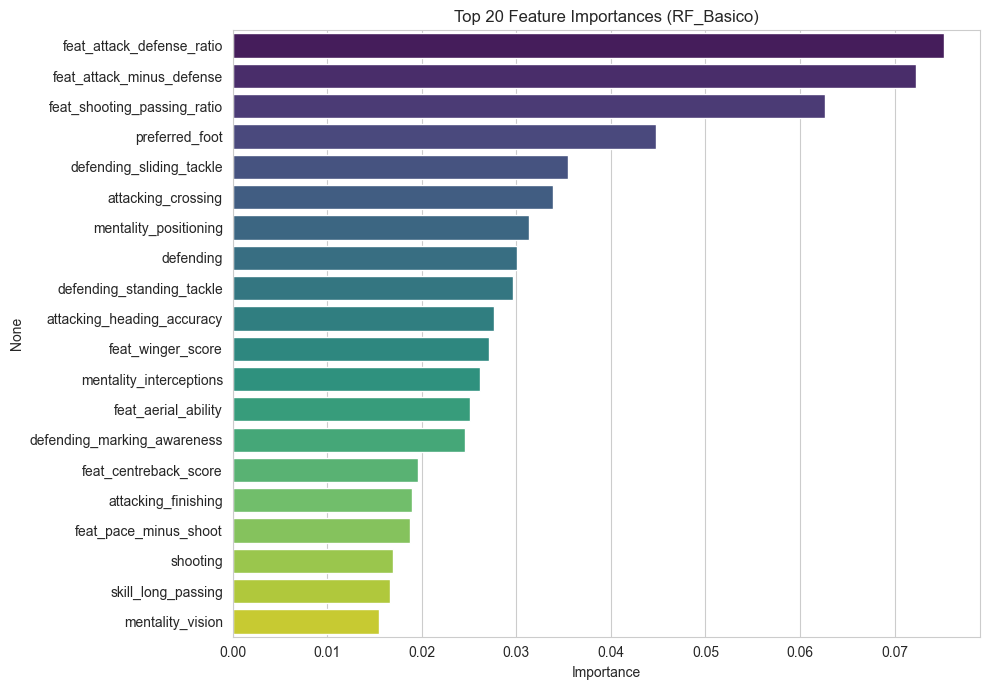

Feature importances salvas em: ../Treino/results\feature_importances_top20.png


In [12]:
sns.set_style('whitegrid')

# Recalcula predições caso necessário
y_test_pred = rf.predict(X_test)

# Série de importâncias
feat_names = X.columns.tolist()
importances = rf.feature_importances_
fi = pd.Series(importances, index=feat_names).sort_values(ascending=False).head(20)

plt.figure(figsize=(10,7))
sns.barplot(x=fi.values, y=fi.index, palette="viridis")
plt.title("Top 20 Feature Importances (RF_Basico)")
plt.xlabel("Importance")
plt.tight_layout()

# Salvar figura
fi_path = os.path.join(RESULTS_DIR, "feature_importances_top20.png")
plt.savefig(fi_path, bbox_inches='tight', dpi=150)
plt.show()

print("Feature importances salvas em:", fi_path)

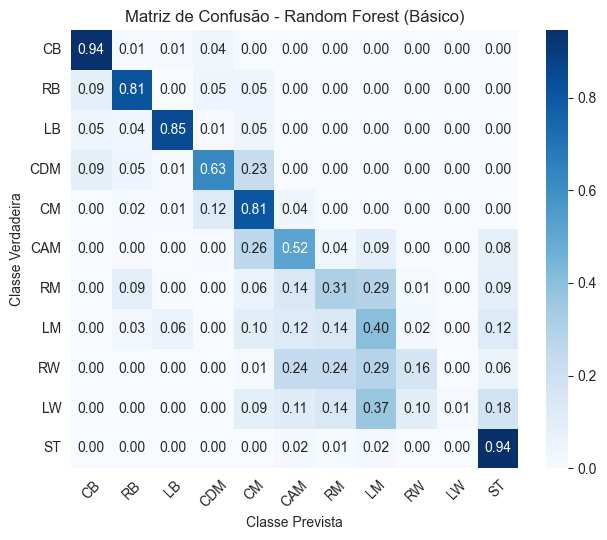

Matriz de confusão salva em: ../Treino/results\confusion_matrix_RF_basico.png


In [13]:
custom_order = ["CB", "RB", "LB", "CDM", "CM", "CAM", "RM", "LM", "RW", "LW", "ST"]
mapping_df = df[['main_position_enc','main_position']].drop_duplicates().sort_values('main_position_enc')
label_map = dict(zip(mapping_df['main_position_enc'], mapping_df['main_position']))
reverse_label_map = {v: int(k) for k, v in label_map.items()}

order_indices = [reverse_label_map[pos] for pos in custom_order if pos in reverse_label_map]

# Matriz Confusão
cm = confusion_matrix(y_test, y_test_pred, labels=order_indices, normalize='true')

display_labels = [pos for pos in custom_order if pos in reverse_label_map]

plt.figure(figsize=(6.5,5.5))
ax = sns.heatmap(
    cm,
    annot=True, fmt=".2f",
    cmap="Blues",
    xticklabels=display_labels,
    yticklabels=display_labels,
    cbar=True,
    linewidths=0,  # <<< remove linhas
    linecolor=None
)
plt.title("Matriz de Confusão - Random Forest (Básico)")
plt.xlabel("Classe Prevista")
plt.ylabel("Classe Verdadeira")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

cm_path = os.path.join(RESULTS_DIR, "confusion_matrix_RF_basico.png")
plt.savefig(cm_path, bbox_inches='tight', dpi=150)
plt.show()

print("Matriz de confusão salva em:", cm_path)

In [25]:
# Salvar label_map (enc -> label)
label_map_path = os.path.join(RESULTS_DIR, "label_map.json")
with open(label_map_path, "w") as f:
    json.dump({str(k): v for k, v in label_map.items()}, f, indent=2, ensure_ascii=False)
print("label_map salvo em:", label_map_path)

# Salvar lista de features que o modelo usa (ordem)
features_path = os.path.join(RESULTS_DIR, "baseline_metrics_v1.json")
with open(features_path, "w") as f:
    json.dump(list(X.columns), f, indent=2)
print("Lista de features salva em:", features_path)

label_map salvo em: ../Treino/results\label_map.json
Lista de features salva em: ../Treino/results\baseline_metrics_v1.json


In [21]:
# Tuning de hiper-parâmetros
param_dist = {
    "n_estimators": [200, 300, 500, 800],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ['sqrt', 'log2', 0.3, 0.5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_base = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)

rs = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=40,               
    scoring='f1_macro',
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

t0 = time.time()
rs.fit(X_train, y_train)
print("RandomizedSearchCV done in %.1f min" % ((time.time()-t0)/60))
print("Best params:", rs.best_params_)
print("Best CV score (f1_macro):", rs.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
RandomizedSearchCV done in 36.8 min
Best params: {'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 0.3, 'max_depth': 30}
Best CV score (f1_macro): 0.5793469129644688


In [22]:
best = rs.best_estimator_

# predições no holdout
y_pred_holdout = best.predict(X_test)

print("Holdout accuracy:", accuracy_score(y_test, y_pred_holdout))
print("Holdout F1-macro:", f1_score(y_test, y_pred_holdout, average='macro'))
print(classification_report(y_test, y_pred_holdout, zero_division=0))

Holdout accuracy: 0.7176506576934842
Holdout F1-macro: 0.591179548215485
              precision    recall  f1-score   support

           0       0.49      0.59      0.53       227
           1       0.94      0.90      0.92       665
           2       0.60      0.68      0.64       287
           3       0.70      0.72      0.71       443
           4       0.85      0.86      0.86       273
           5       0.33      0.33      0.33       213
           6       0.24      0.11      0.15        79
           7       0.76      0.85      0.80       285
           8       0.38      0.32      0.35       203
           9       0.37      0.26      0.31        87
          10       0.90      0.91      0.91       507

    accuracy                           0.72      3269
   macro avg       0.60      0.59      0.59      3269
weighted avg       0.71      0.72      0.71      3269



In [36]:
# caminhos
MODEL_PATH = "./models/rf_baseline_v1.pkl"   # ajuste se necessário
os.makedirs(RESULTS_DIR, exist_ok=True)

rf_baseline = joblib.load(MODEL_PATH)

y_pred_baseline = rf_baseline.predict(X_test)
baseline_metrics = {
    "holdout_accuracy": float(accuracy_score(y_test, y_pred_baseline)),
    "holdout_f1_macro": float(f1_score(y_test, y_pred_baseline, average='macro')),
    "model": "rf_baseline_v1"
}

with open(os.path.join(RESULTS_DIR, "baseline_metrics_v1_correct.json"), "w") as f:
    json.dump(baseline_metrics, f, indent=2)

print("Baseline computado e salvo em:", os.path.join(RESULTS_DIR, "baseline_metrics_v1_correct.json"))
print("Baseline metrics:", baseline_metrics)
print("\nClassification report (baseline):\n")
print(classification_report(y_test, y_pred_baseline, zero_division=0))

Baseline computado e salvo em: ./results\baseline_metrics_v1_correct.json
Baseline metrics: {'holdout_accuracy': 0.7301927194860813, 'holdout_f1_macro': 0.5797098314506545, 'model': 'rf_baseline_v1'}

Classification report (baseline):

              precision    recall  f1-score   support

           0       0.51      0.52      0.51       227
           1       0.91      0.94      0.92       665
           2       0.65      0.63      0.64       287
           3       0.65      0.81      0.72       443
           4       0.89      0.85      0.87       273
           5       0.37      0.40      0.39       213
           6       1.00      0.01      0.03        79
           7       0.79      0.81      0.80       285
           8       0.46      0.31      0.37       203
           9       0.47      0.16      0.24        87
          10       0.85      0.94      0.90       507

    accuracy                           0.73      3269
   macro avg       0.68      0.58      0.58      3269
weight

In [35]:
best_path = os.path.join(RESULTS_DIR, "rf_tuned_v1.pkl")
joblib.dump(best, best_path)

metrics_tuned = {
    "holdout_accuracy": float(accuracy_score(y_test, y_pred_holdout)),
    "holdout_f1_macro": float(f1_score(y_test, y_pred_holdout, average='macro')),
    "best_params": rs.best_params_,
    "cv_best_score": float(rs.best_score_)
}
with open(os.path.join(RESULTS_DIR, "tuned_metrics_v1.json"), "w") as f:
    json.dump(metrics_tuned, f, indent=2)

Best estimator encontrado via rs.best_estimator_.
Modelo tunado salvo em: ./models\rf_tuned_v1_20251113_2227.pkl
cv_results_ salvo em: ./results\cv_results_random_search_20251113_2227.csv
Métricas tunadas salvas em: ./results\tuned_metrics_v1.json
{'model': 'rf_tuned_v1_20251113_2227.pkl', 'holdout_accuracy': 0.7176506576934842, 'holdout_f1_macro': 0.591179548215485, 'best_params': {'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 0.3, 'max_depth': 30}, 'cv_best_score': 0.5793469129644688}
Classification report salvo em: ./results\classification_report_tuned_20251113_2227.csv


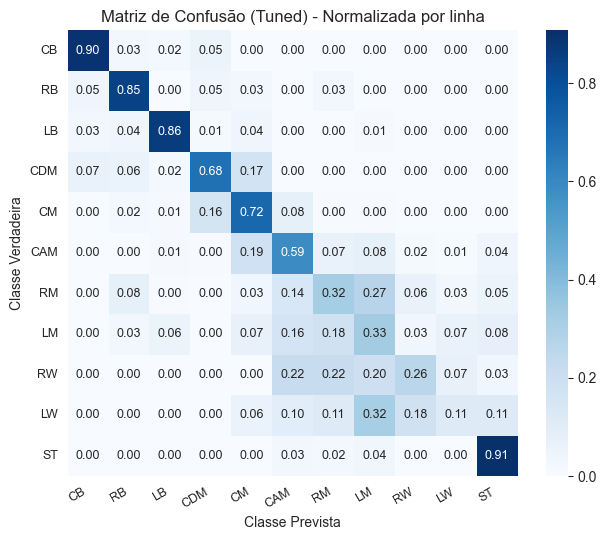

Matriz de confusão (tuned) salva em: ./results\confusion_matrix_tuned_20251113_2227.png
Lista de features salva em: ./results\features_used_v1.json


In [46]:

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

# 1) extrair o best estimator do RandomizedSearchCV (rs)
try:
    best_model = rs.best_estimator_
    print("Best estimator encontrado via rs.best_estimator_.")
except NameError:
    raise RuntimeError("Objeto 'rs' não encontrado. Rode a célula do RandomizedSearchCV novamente.")
except Exception as e:
    raise RuntimeError("Erro ao acessar rs.best_estimator_: " + str(e))

# 2) salvar o modelo tunado com timestamp
ts = time.strftime("%Y%m%d_%H%M")
tuned_model_path = os.path.join(MODELS_DIR, f"rf_tuned_v1_{ts}.pkl")
joblib.dump(best_model, tuned_model_path)
print("Modelo tunado salvo em:", tuned_model_path)

# 3) salvar cv_results em CSV (útil para análise)
try:
    cv_df = pd.DataFrame(rs.cv_results_)
    cv_csv_path = os.path.join(RESULTS_DIR, f"cv_results_random_search_{ts}.csv")
    cv_df.to_csv(cv_csv_path, index=False)
    print("cv_results_ salvo em:", cv_csv_path)
except Exception as e:
    print("Não foi possível salvar cv_results_: ", e)

# 4) avaliar o modelo tunado no holdout (X_test/y_test)
y_pred_tuned = best_model.predict(X_test)
tuned_metrics = {
    "model": os.path.basename(tuned_model_path),
    "holdout_accuracy": float(accuracy_score(y_test, y_pred_tuned)),
    "holdout_f1_macro": float(f1_score(y_test, y_pred_tuned, average='macro')),
    "best_params": rs.best_params_,
    "cv_best_score": float(rs.best_score_)
}

tuned_metrics_path = os.path.join(RESULTS_DIR, "tuned_metrics_v1.json")
with open(tuned_metrics_path, "w") as f:
    json.dump(tuned_metrics, f, indent=2)
print("Métricas tunadas salvas em:", tuned_metrics_path)
print(tuned_metrics)

# 5) classification report em CSV
report_dict = classification_report(y_test, y_pred_tuned, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report_dict).T
report_csv = os.path.join(RESULTS_DIR, f"classification_report_tuned_{ts}.csv")
report_df.to_csv(report_csv)
print("Classification report salvo em:", report_csv)

# 6) matriz de confusão (normalizada por linha) - salvar figura
# se tiver label_map (enc -> sigla) usa ordem personalizada se quiser
custom_order = ["CB", "RB", "LB", "CDM", "CM", "CAM", "RM", "LM", "RW", "LW", "ST"]
# tenta reconstruir label_map a partir do df se existir; caso contrário, usa le (LabelEncoder)
if 'label_map' not in globals():
    try:
        mapping_df = df[['main_position_enc','main_position']].drop_duplicates().sort_values('main_position_enc')
        label_map = dict(zip(mapping_df['main_position_enc'], mapping_df['main_position']))
        print("label_map reconstruído a partir do DataFrame.")
    except Exception:
        label_map = None

# build reverse map label->enc se label_map existir
order_indices = None
display_labels = None
if label_map:
    reverse_label_map = {v:int(k) for k,v in label_map.items()}
    order_indices = [reverse_label_map[pos] for pos in custom_order if pos in reverse_label_map]
    display_labels = [pos for pos in custom_order if pos in reverse_label_map]

# calcular cm normalizada por linha
if order_indices is not None:
    cm = confusion_matrix(y_test, y_pred_tuned, labels=order_indices, normalize='true')
    labels_for_plot = display_labels
else:
    cm = confusion_matrix(y_test, y_pred_tuned, normalize='true')
    # labels a partir do mapping_df se disponível, ou indices
    if label_map:
        labels_for_plot = [label_map[i] for i in sorted(label_map.keys())]
    else:
        labels_for_plot = None

# plot compacto
plt.figure(figsize=(6.5,5.5))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=labels_for_plot, yticklabels=labels_for_plot,
            linewidths=0, annot_kws={"size":9})
plt.title("Matriz de Confusão (Tuned) - Normalizada por linha")
plt.xlabel("Classe Prevista")
plt.ylabel("Classe Verdadeira")
plt.xticks(rotation=30, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()

cm_path = os.path.join(RESULTS_DIR, f"confusion_matrix_tuned_{ts}.png")
plt.savefig(cm_path, bbox_inches='tight', dpi=150)
plt.show()
print("Matriz de confusão (tuned) salva em:", cm_path)

# 7) salvar lista de features usada (garantir reprodutibilidade)
features_path = os.path.join(RESULTS_DIR, "features_used_v1.json")
try:
    with open(features_path, "w") as f:
        json.dump(list(X.columns), f, indent=2)
    print("Lista de features salva em:", features_path)
except Exception as e:
    print("Não foi possível salvar features list:", e)

label_map_path = os.path.join(RESULTS_DIR, "label_map.json")



Carregado modelo em: ./models\rf_baseline_v1.pkl
Baseline metrics salvas em: ./results\baseline_metrics_v1.json
Baseline metrics: {'holdout_accuracy': 0.7301927194860813, 'holdout_f1_macro': 0.5797098314506545, 'model': 'rf_baseline_v1.pkl'}
Tuned metrics carregadas de: ./results\tuned_metrics_v1.json


,accuracy,f1_macro
model,,
baseline,0.730193,0.57971
tuned,0.717651,0.59118


Plot salvo em: ./results\comparison_baseline_vs_tuned_auto.png
Classification report baseline salvo em: ./results\classification_report_baseline.csv
Nenhum modelo tuned salvo em ./models\rf_tuned_v1.pkl - se você tiver tuned model .pkl, coloque em models/ e o bloco irá gerar o report.
Comparação concluída. Verifique ./results para os arquivos gerados.


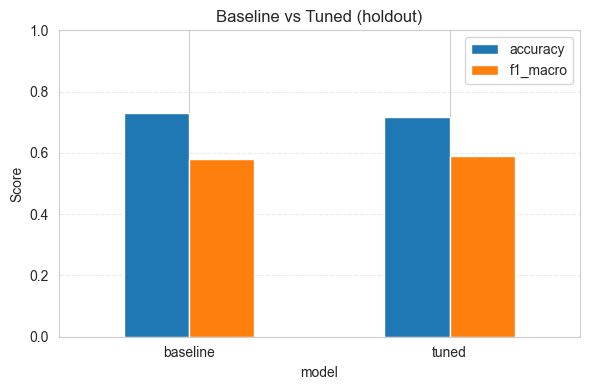

In [40]:

os.makedirs(RESULTS_DIR, exist_ok=True)

# 1) localizar ou carregar baseline model ------------------------------------
baseline_model = None
baseline_model_path = os.path.join(MODELS_DIR, "rf_baseline_v1.pkl")

def try_load(path):
    try:
        m = joblib.load(path)
        print(f"Carregado modelo em: {path}")
        return m
    except Exception as e:
        print(f"Falha ao carregar {path}: {e}")
        return None

# tentativa 1: caminho padrão
if os.path.exists(baseline_model_path):
    baseline_model = try_load(baseline_model_path)

# tentativa 2: variável 'rf' em memória (nome comum do baseline no notebook)
if baseline_model is None and 'rf' in globals():
    try:
        # checar se é um estimator
        if hasattr(globals()['rf'], 'predict'):
            baseline_model = globals()['rf']
            print("Usando variável 'rf' em memória como baseline.")
    except Exception:
        pass

# tentativa 3: procurar arquivos possíveis em models/
if baseline_model is None:
    candidates = glob.glob(os.path.join(MODELS_DIR, "*baseline*.pkl")) + glob.glob(os.path.join(MODELS_DIR, "rf*baseline*.pkl")) + glob.glob(os.path.join(MODELS_DIR, "rf_baseline*.pkl"))
    candidates = list(dict.fromkeys(candidates))  # único
    if candidates:
        print("Candidatos encontrados:", candidates)
        for p in candidates:
            baseline_model = try_load(p)
            if baseline_model is not None:
                baseline_model_path = p
                break

# tentativa 4: procurar qualquer modelo pkl no projeto e usar o primeiro (fallback)
if baseline_model is None:
    all_pkls = glob.glob("**/*.pkl", recursive=True)
    if all_pkls:
        print("Nenhum baseline óbvio encontrado — tentando primeiro .pkl disponível:", all_pkls[0])
        baseline_model = try_load(all_pkls[0])
        baseline_model_path = all_pkls[0] if baseline_model is not None else baseline_model_path

if baseline_model is None:
    raise FileNotFoundError("Não foi possível localizar nem carregar um modelo baseline. Verifique se existe um .pkl ou se a variável 'rf' está em memória.")

# 2) calcular métricas do baseline no holdout (usando X_test,y_test) ----------
# requer que X_test e y_test existam no ambiente
if 'X_test' not in globals() or 'y_test' not in globals():
    raise RuntimeError("X_test ou y_test não encontrados no ambiente — rode as células de split antes.")

y_pred_baseline = baseline_model.predict(X_test)
baseline_metrics = {
    "holdout_accuracy": float(accuracy_score(y_test, y_pred_baseline)),
    "holdout_f1_macro": float(f1_score(y_test, y_pred_baseline, average='macro')),
    "model": os.path.basename(baseline_model_path)
}

# salvar baseline metrics
baseline_out_path = os.path.join(RESULTS_DIR, "baseline_metrics_v1.json")
with open(baseline_out_path, "w") as f:
    json.dump(baseline_metrics, f, indent=2)
print("Baseline metrics salvas em:", baseline_out_path)
print("Baseline metrics:", baseline_metrics)

# 3) carregar tuned metrics (se existir) -------------------------------------
tuned_path = os.path.join(RESULTS_DIR, "tuned_metrics_v1.json")
tuned_metrics = None
if os.path.exists(tuned_path):
    tuned_metrics = json.load(open(tuned_path))
    print("Tuned metrics carregadas de:", tuned_path)
else:
    print("Nenhum tuned_metrics_v1.json encontrado em", RESULTS_DIR, "- será feito apenas baseline.")

# 4) construir tabela de comparação e plot -----------------------------------
rows = []
rows.append({
    "model": "baseline",
    "accuracy": baseline_metrics.get("holdout_accuracy"),
    "f1_macro": baseline_metrics.get("holdout_f1_macro")
})
if tuned_metrics:
    rows.append({
        "model": "tuned",
        "accuracy": tuned_metrics.get("holdout_accuracy") or tuned_metrics.get("holdout_accuracy"),
        "f1_macro": tuned_metrics.get("holdout_f1_macro") or tuned_metrics.get("holdout_f1_macro")
    })

comp_df = pd.DataFrame(rows).set_index("model")
display(comp_df)

# plot
ax = comp_df.plot(kind="bar", figsize=(6,4), ylim=(0,1), rot=0)
ax.set_ylabel("Score")
plt.title("Baseline vs Tuned (holdout)")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plot_path = os.path.join(RESULTS_DIR, "comparison_baseline_vs_tuned_auto.png")
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print("Plot salvo em:", plot_path)

# 5) classification reports (salvar) ----------------------------------------
# salvar classification report do baseline
report_baseline = classification_report(y_test, y_pred_baseline, output_dict=True, zero_division=0)
pd.DataFrame(report_baseline).T.to_csv(os.path.join(RESULTS_DIR, "classification_report_baseline.csv"))
print("Classification report baseline salvo em:", os.path.join(RESULTS_DIR, "classification_report_baseline.csv"))

# se tuned_model.pkl estiver disponível, também calcule relatório do tuned
tuned_model_path = os.path.join(MODELS_DIR, "rf_tuned_v1.pkl")
if os.path.exists(tuned_model_path):
    try:
        tuned_model = joblib.load(tuned_model_path)
        y_pred_tuned = tuned_model.predict(X_test)
        report_tuned = classification_report(y_test, y_pred_tuned, output_dict=True, zero_division=0)
        pd.DataFrame(report_tuned).T.to_csv(os.path.join(RESULTS_DIR, "classification_report_tuned.csv"))
        print("Classification report tuned salvo em:", os.path.join(RESULTS_DIR, "classification_report_tuned.csv"))
    except Exception as e:
        print("Falha ao carregar/taxar tuned_model em", tuned_model_path, ":", e)
else:
    print("Nenhum modelo tuned salvo em", tuned_model_path, "- se você tiver tuned model .pkl, coloque em models/ e o bloco irá gerar o report.")

print("Comparação concluída. Verifique", RESULTS_DIR, "para os arquivos gerados.")